# Define packages and hyperparameters

In [1]:
import os
import os.path as osp
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Y_FEATURE = 'diagnosis'
X_FEATURES = ['radius_mean', 'texture_mean', 'perimeter_mean',
              'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
              'concave points_mean', 'concavity_mean', 'fractal_dimension_mean',
              'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
              'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
              'fractal_dimension_se', 'radius_worst', 'texture_worst',
              'perimeter_worst', 'area_worst', 'smoothness_worst',
              'compactness_worst', 'concavity_worst', 'concave points_worst',
              'symmetry_worst', 'fractal_dimension_worst']
DISTRIBUTION_MODES = ["setting1", "setting2", "setting3"]
STATION_LIST = ["uka", "umg", "ukk", "ukl", "imise", "hsm"]

def fix_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
fix_all_seeds(2021)

# Load data from Google drive or download from GitHub

In [2]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/DSM-AS/input"
OUTPUT_DIR = "/content/drive/MyDrive/DSM-AS/output"
data_df = pd.read_csv(osp.join(BASE_DIR, "data.csv"))
if not osp.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Using PCA find important features

In [3]:
scaler = MinMaxScaler()
X = data_df[X_FEATURES]
y = data_df[Y_FEATURE].map({'B': 0, 'M': 1})
X_rescaled = scaler.fit_transform(X)
pca = PCA().fit(X_rescaled)

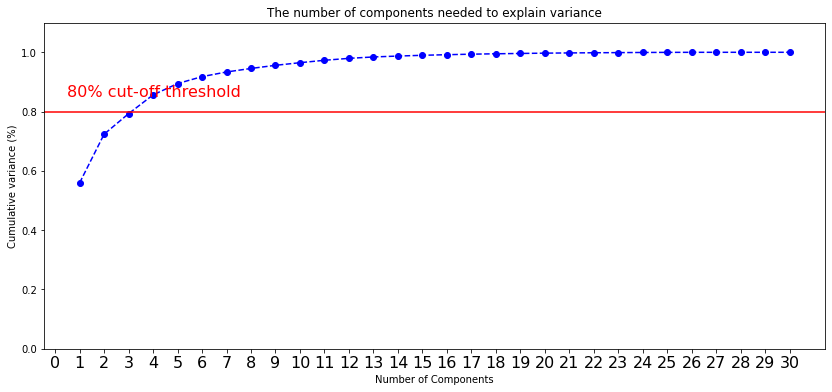

In [4]:
plt.figure(figsize=(14,6))
xi = np.arange(1, 31, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 31, step=1), fontsize=16) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.axhline(y=0.80, color='r', linestyle='-')
plt.text(0.5, 0.85, '80% cut-off threshold', color = 'red', fontsize=16)

plt.savefig(osp.join(OUTPUT_DIR, "pca_1.png"))

# Train a new PCA model with 3 components

Most important features: ['concave points_worst', 'fractal_dimension_mean', 'texture_worst']


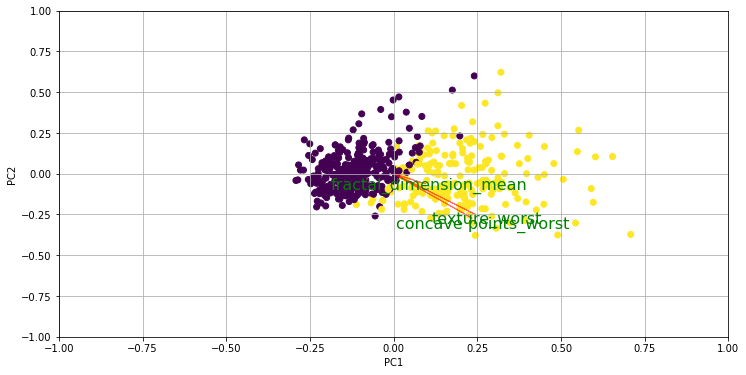

In [5]:
n_components=3
pca_new = PCA(n_components=n_components).fit(X_rescaled)
X_pca = pca_new.transform(X_rescaled)
n_pcs= pca_new.components_.shape[0]
# print(pca_new.components_.shape)
most_important_features = [np.abs(pca_new.components_[i]).argmax() for i in range(n_pcs)]
# print(most_important)
most_important_features_names = [X_FEATURES[most_important_features[i]] for i in range(n_pcs)]
print("Most important features:", most_important_features_names)
plt.figure(figsize=(12,6))
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
xs = X_pca[:,0:n_components-1][:,0]
ys = X_pca[:,0:n_components-1][:,1]
coeff = np.transpose(pca.components_[0:n_components-1, :])
y = data_df[Y_FEATURE].map({'B': 0, 'M': 1})
# n = coeff.shape[0]
n = 3
labels = most_important_features_names
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.scatter(xs * scalex, ys * scaley, c = y)
for i in range(n):
    plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
    if labels is None:
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center', fontsize=16)
    else:
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center', fontsize=16)

plt.savefig(osp.join(OUTPUT_DIR, "pca_2.png"))

In [6]:
eda_df = pd.DataFrame(columns=["id", *most_important_features_names, "station", "setting"])
for dist_i in range(len(DISTRIBUTION_MODES)):
    distribution_mode = DISTRIBUTION_MODES[dist_i]
    for station in STATION_LIST:
        station_df = pd.read_csv(osp.join(BASE_DIR, "{}/{}.csv".format(distribution_mode, station))).rename(columns={"patient_id":"id"})
        station_df["id"] = station_df["id"].map(lambda x: int(x[6:]))
        station_df = pd.merge(data_df[["id", *most_important_features_names]], station_df, on='id', how='right')
        station_df["station"] = station.upper()
        station_df["setting"] = "Setting {}".format(dist_i + 1)
        eda_df = pd.concat([eda_df, station_df])    

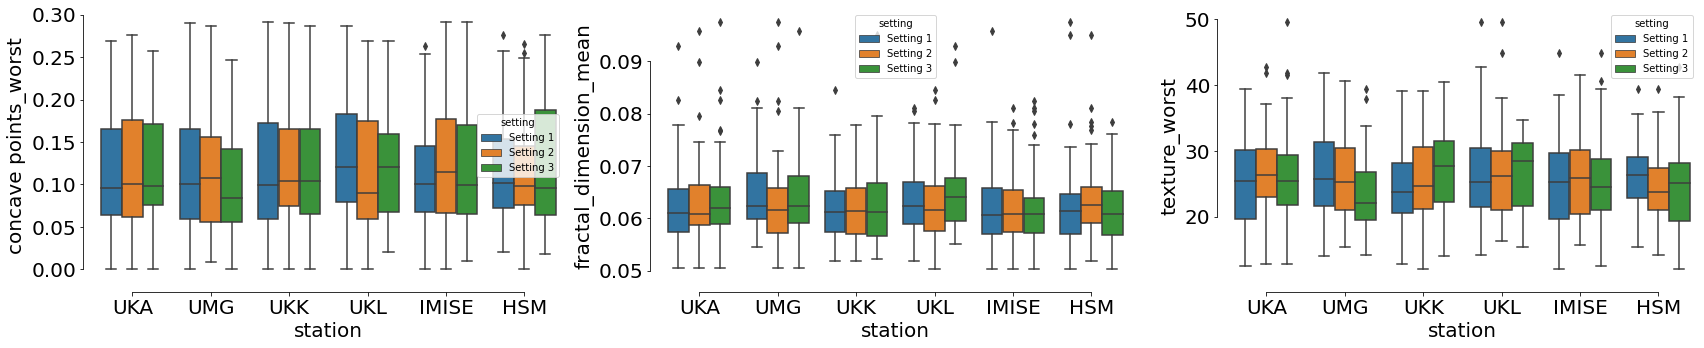

In [7]:
plt.figure(figsize = (24,5))
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
for i in range(len(most_important_features_names)):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    sns.boxplot(x="station", y=most_important_features_names[i], hue="setting", data=eda_df)
    sns.despine(offset=10, trim=True)

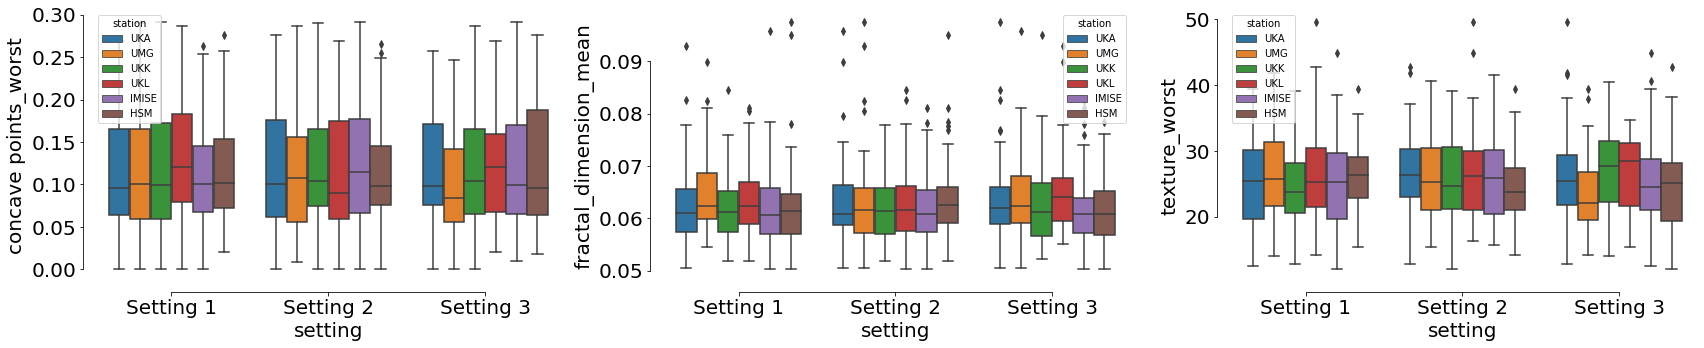

In [8]:
plt.figure(figsize = (24,5))
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
for i in range(len(most_important_features_names)):
    plt.subplot(1,3,i+1)
    plt.tight_layout()
    sns.boxplot(x="setting", y=most_important_features_names[i], hue="station", data=eda_df)
    sns.despine(offset=10, trim=True)

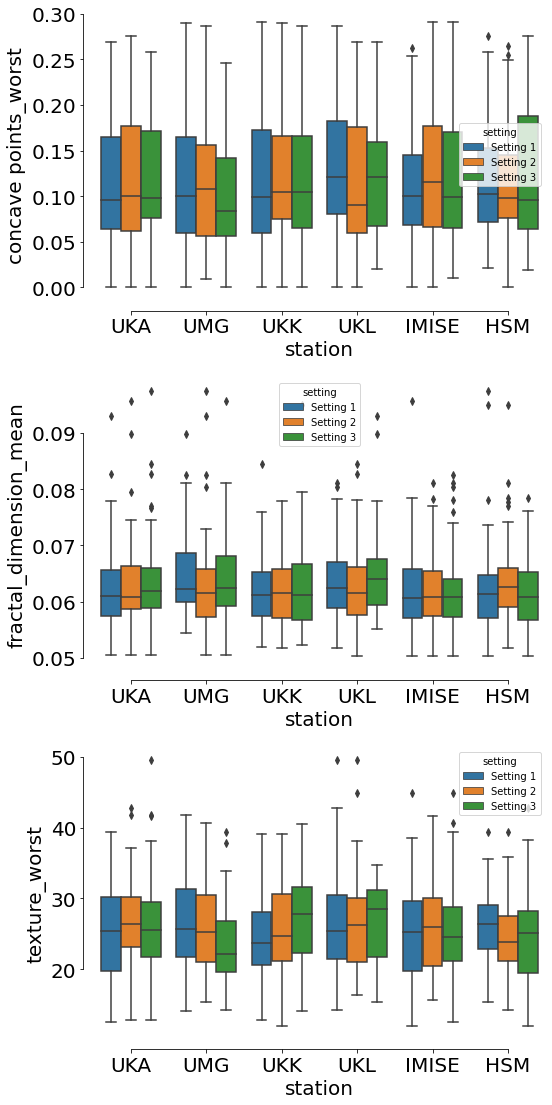

In [9]:
plt.figure(figsize = (8,15))
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
for i in range(len(most_important_features_names)):
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    sns.boxplot(x="station", y=most_important_features_names[i], hue="setting", data=eda_df)
    sns.despine(offset=10, trim=True)

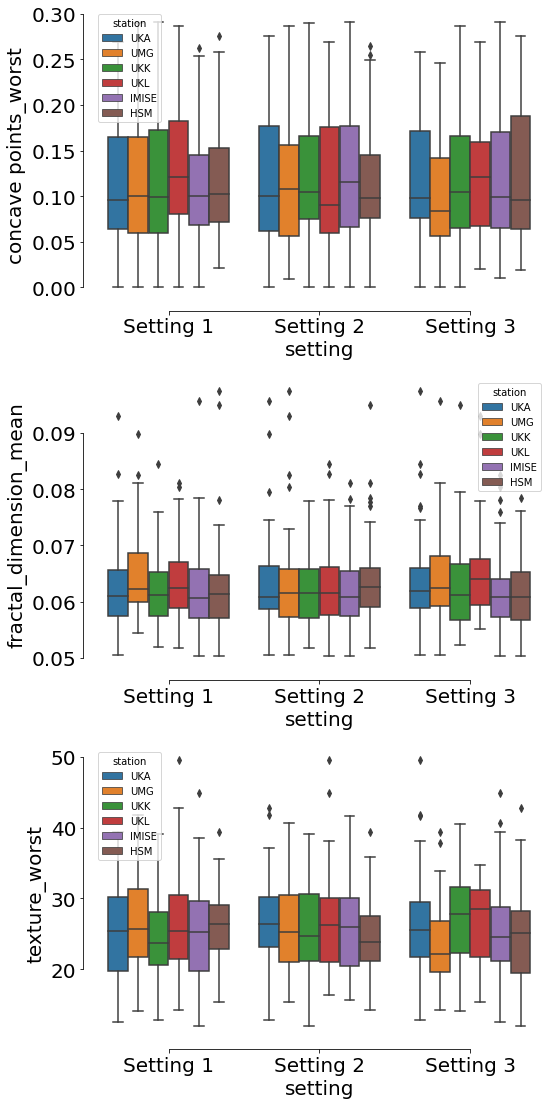

In [10]:
plt.figure(figsize = (8,15))
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
for i in range(len(most_important_features_names)):
    plt.subplot(3,1,i+1)
    plt.tight_layout()
    sns.boxplot(x="setting", y=most_important_features_names[i], hue="station", data=eda_df)
    sns.despine(offset=10, trim=True)

In [11]:
# plt.savefig(osp.join(OUTPUT_DIR, "feats_boxplots.png"))